# Musical Patterns

An introduction to musical pattern generation in musx.

<hr style="height:1px;color:gray">

Notebook imports:

In [2]:
import sys
sys.path.append('/Users/taube/Software/musx')
import matplotlib.pyplot as plt
from random import randint
from musx import version, Cycle, Choose, Palindrome, Shuffle, Rotation, Markov, States, setmidiplayer, between
print(f"musx version: {version}")

musx version: N.N.N


Generate midi files and automatically play them using [fluidsynth](https://www.fluidsynth.org/download/) and the [MuseScore_General.sf3](https://ftp.osuosl.org/pub/musescore/soundfont/MuseScore_General) sound font. See [INSTALL.md](https://github.com/musx-admin/musx/blob/main/INSTALL.md) for how to install a terminal based midi player to use with musx.  If you dont have a player installed you can access the output files in the same directory as this notebook:

In [3]:
setmidiplayer("fluidsynth -iq -g1 /usr/local/sf/MuseScore_General.sf3")

## Musical patterns in musx

Music is brimming with patterns! Composers are always looking for new ways to organize notes, rhythms, even elements of form. By encorporating patterns at various levels of their music composers can control the "mix" of new and heard-before ideas in artistic and interesting ways. 

In terms of coding, a pattern is a resource that generates data in a particular ordering. Since there are so many kinds of patterns in music, it is useful to have a toolbox of generic patterns and a way to implement new ones.

In musx patterns are subclasses of a Pattern base class that implements an object-orientated interface for generating data, from simple looping and randomness to more complex processes such as markov chains, cellular automata and chaos.  
Many of these patterns allow subpatterns to be embedded inside parent patterns and processed seamlessly by the Pattern's `next()` method.  Patterns that support embedding have a 'period' argument that regulate how many items are read from it before a parent pattern can move to its next item. The period value can be expressed as a constant value or a pattern of values.

We will take a first look at these concepts using the simplest musx pattern, the Cycle.

## The Cycle pattern

```Cycle(items, period=None)```

A Cycle pattern generates items in an endless loop from front to back. 

In [ ]:
pat = Cycle([1,2,3,4])
print(f"pat: {pat}")

### Reading pattern data

To read data from a pattern call its `next()` method, which supports additional features not available in python's builtin `next()` function.


`Pattern.next(more=False)`

The pattern `next()` provides a *more* argument that allow pattern items to be accessed in several different ways.  

If the more argument is False (the default), then next() returns just the next item from the pattern:

In [ ]:
pat = Cycle([1,2,3,4])
print(f"next: {pat.next()}")
print(f"next: {pat.next()}")
print(f"next: {pat.next()}")
print(f"next: {pat.next()}")

If the *more* argument is an integer then `next()`` returns that many elements from the pattern. In this next example the cyclic ordering 1, 2, 3, 4 is perserved in the output no matter how many items are returned in each call. 
The length of values returned is called the *period* of the pattern:

In [ ]:
pat = Cycle([1,2,3,4])
print(f"pat: {pat}")
print(f"next: {pat.next(7)}")
print(f"next: {pat.next(4)}")
print(f"next: {pat.next(1)}")
print(f"next: {pat.next(5)}")

### Pattern periods

Most patterns allow a period length to be specifed to a pattern when it is created. Patterns that allow this also provide a default period length if one is not provided by the caller.  

In this next example, the period becomes something that the pattern controls internally. To tell the pattern to use its  intranl period pass True to the *more* parameter, as seen in this example:

In [ ]:
pat = Cycle([1,2,3,4], period=3)
print(f"pat: {pat}")
print(f"next: {pat.next(True)}")
print(f"next: {pat.next(True)}")
print(f"next: {pat.next(True)}")
print(f"next: {pat.next(True)}")

Note that True actually returns the *remaining* items in a period; this keeps ordering in sync no matter what you pass to next()'s *more* argument when you call it.

In [ ]:
pat = Cycle([1,2,3,4], period=4)
print(f"pat: {pat}")
print(f"reading remaining items in period: {pat.next(True)}")
print(f"reading 1 item: {pat.next()}")
print(f"reading remaining items in period: {pat.next(True)}")
print(f"reading 3 items: {pat.next(3)}")
print(f"reading remaining items in period: {pat.next(True)}")
print(f"reading remaining items in period: {pat.next(True)}")

The period of a pattern can also be specified as a _pattern_ of integers, in which case the pattern's period will vary accordingly. In this next example, the length of the period `next(True)` will cycle through the lengths 5, 6, 7.

In [ ]:
pat = Cycle([1,2,3,4], period=Cycle([5,6,7]))
print(f"pat: {pat}")
for _ in range(7):
    print(f"next: {pat.next(True)}")

### Embedded subpatterns

The period length is particularly important when working with *embedded* patterns, i.e. subpatterns.
In this example, an outer cyclic pattern contains an embedded cyclic pattern. The outer pattern cycles through four items: [10, *subpattern*, 20, 30], the subpattern cycles through two items: [-1, -2].  

In [ ]:
pat = Cycle(['a', 
             Cycle([-1, -2], period=Cycle([1,2,3])), 
             'b', 
             'c'])
print(f"{pat.next(20)}")

Note that each time the subpattern is encountered it yields 1, 2 or 3 of its items before the outer pattern can move on to its next item. The overall pattern is a merge of two streams of cyclic data: an outer pattern of 10, 20, 30...
and an inner pattern -1, -2... In this image the yields from each pattern are marked by '**'.
```
outer:  **       **   **   **           **   **   **               **  **  **         **  **  **
       ['a', -1, 'b', 'c', 'a', -2, -1, 'b', 'c', 'a', -2, -1, -2, 'b', 'c', 'a', -1, 'b', 'c', 'a']
inner:       **                 **  **                 **  **  **                 ** 
```

### Embedded expressions

You can also embed python expressions inside patterns to calculate new values to return each time `next()` encounters them in the pattern. To embed an expression wrap it in a 'thunk', i.e. a lambda expression or function of zero arguments, and give the thunk as an element to the pattern. 

In this example the constants 'a' 'b' and 'c' are interleaved with two lambda expressions:

In [5]:
items = ['a', lambda: between(10, 20), 'b', lambda: between(-20, -10), 'c']

print(f"data: {Cycle(items).next(20)}")

data: ['a', 10, 'b', -12, 'c', 'a', 18, 'b', -12, 'c', 'a', 15, 'b', -14, 'c', 'a', 10, 'b', -19, 'c']


### The takeaway

The basic rule to remember for most musx patterns is that constant data can usually be replaced by patterns or expressions of data, and embedded to any level in (other) patterns.

## The Palindrome pattern

```palindrome(items, period=None, wrap='++')```

The Palindrome pattern returns items both forwards and backwards. The `wrap` argument is a two character token that determines if the first or last elements are directly repeated when the pattern reverses: the first token applies to the first item and the second item applies to the second.  The '+' token means the element is repeated and '-' means it is not repeated.
<!-- The Palindrome pattern returns its items both forwards and backwards. The `wrap` argument is a two character token that determines if the first and/or last elements are directly repeated when the pattern reverses: the + means the first or last element is directly repeated and the - means it is not. -->

This palindrome uses the default wrap value ('++') which means that both the front and back items repeat on reversal:

In [ ]:
pat = Palindrome([1,2,3])
for _ in range(3):
    print(f"pat: {pat.next(True)}")

This Palindrome repeats only the front item on reversal:

In [ ]:
pat = Palindrome([1,2,3], wrap='+-')
for _ in range(3):
    print(f"pat: {pat.next(True)}")

This palindrome repeats only the back item on reversal:

In [ ]:
pat = Palindrome([1,2,3], wrap='-+')
for _ in range(3):
    print(f"pat: {pat.next(True)}")

If wrap includes only '-' signs the palindrome does not repeat either the front or back item on reversal:

In [4]:
pat = Palindrome([1,2,3], wrap='--')
for _ in range(3):
    print(f"pat: {pat.next(True)}")

pat: [1, 2, 3, 2]
pat: [1, 2, 3, 2]
pat: [1, 2, 3, 2]


## The Choose pattern

```Choose(items, weights=[])```

The Choose pattern performs weighted random selection to yield the next item. The *weights* argument allows the caller to pass a list of relative weights for each item. If a *weights* argument is not provided all items will have an equal probability of being selected.

Support for displaying results of 1000 Choose values. If matplotlib is available a graphic image as well a histogram dictionary will be presented:

In [9]:
try: 
    import matplotlib.pyplot as plt
    plot = True
except:
    plot = False

print(f"Matplotlib {'is' if plot else 'not'} installed, results will {'include' if plot else 'omit'} a graphic image :{')' if plot else '('}")
    
def hist (data):
    d = dict.fromkeys(sorted(data))
    for i in d:
        d[i] = data.count(i)
    print(f"histogram: {d}")
    if plotting:
        plt.hist(data)

Matplotlib is installed, results will include a graphic image :)


Histogram of equal probabilities:

histogram: {'A': 323, 'B': 346, 'C': 331}


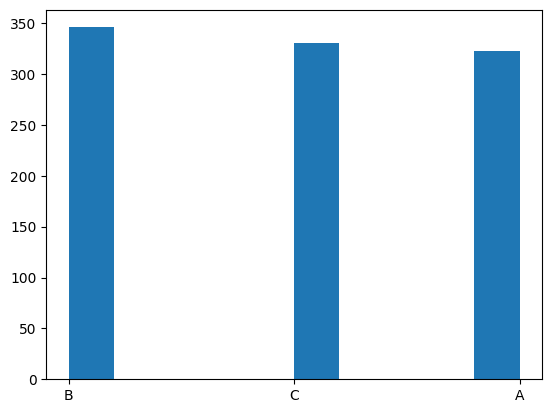

In [6]:
data = Choose(['A','B','C']).next(1000)
hist(data)

Histogram of 1000 datapoints yields weighted probabilities where the value 'B' is four as likely as 'A' and value 'C' is two times as likely:

histogram: {'A': 139, 'B': 567, 'C': 294}
None


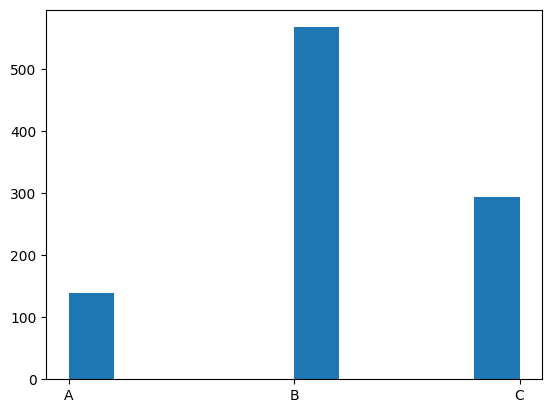

In [7]:
data = Choose(['A','B','C'], [1,4,2]).next(1000)
print(hist(data))

## The Shuffle pattern

```Shuffle(items, norep=False)```

The Shuffle pattern returns random permutations of its items.  To disallow immediate repetition of an item after reshuffling (e.g. the previous choice will also be the next choice) specify True to the *norep* parameter.

In this example *norep* is False, so an item can repeat after every three values:

In [10]:
data = Shuffle(['a','b','c']).next(21)
print(f"data: {data}")

data: ['a', 'c', 'b', 'a', 'c', 'b', 'b', 'a', 'c', 'a', 'b', 'c', 'a', 'c', 'b', 'b', 'a', 'c', 'a', 'c', 'b']


If the *norep* parameter is True, the pattern rejects shuffles that would repeat the last item as the next item. 

In [ ]:
data = Shuffle(['a','b','c'], norep=True).next(21)
print(f"data: {data}")

Musical example of Shuffle patterns that generate a series of jazz sonorities each of which is made up of a mix of 3, 4, or 5 notes from a dorian scale.

In [13]:
from musx import keynum, intempo, Note, Seq, Score, MidiFile, playfile

def playjazzriffs(score, num, amp):
    keypat = Cycle([Shuffle(keynum("c6 d ef f g a bf"), Choose([3, 4, 5])),
                    Shuffle(keynum("c5 d ef f g a bf"), Choose([3, 4, 5])),
                    Shuffle(keynum("c4 d ef f g a bf"), Choose([3, 4, 5]))
                    ], period=1)
    rhypat = Cycle([1, 1, 1, .5])
    for _ in range(num):
        rhy = intempo(rhypat.next(), 160)
        chd = keypat.next(True)
        score.add( Note(time=score.now, duration=rhy, pitch=chd, amplitude=amp))
        yield rhy

# Create a score and give it a seq to hold the score event data.
score = Score(out=Seq())
score.compose(playjazzriffs(score, 30, .8))
# Write the tracks to a midi file in the current directory.
file = MidiFile("jazzriff.mid", score.out).write()
print(f"Wrote '{file.pathname}'.")
playfile(file.pathname)

Wrote 'jazzriff.mid'.
